# Testing DEMV on Drug Dataset

- Sensitive group: white women (`race: 1, gender: 0`)
- Positive label: never (0)

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, GridSearch

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [2]:
def prepare_data():
  data = pd.read_csv('data2/drugs.csv')
  data.drop(['yhat','a'], axis=1, inplace=True)
  data.loc[data['gender']==0.48246,'gender']=1
  data.loc[data['gender']==-0.48246,'gender']=0
  data['y'].replace({
    'never': 0,
    'not last year': 1,
    'last year': 2}, inplace=True)
  data['race'].replace({
    'non-white': 0,
    'white': 1}, inplace=True)
  string_cols = data.dtypes[data.dtypes == 'object'].index.values
  data.drop(string_cols, axis=1, inplace=True)
  return data


In [3]:
data = prepare_data()

In [4]:
data

,id,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss,y,race
0,1,0.49788,1.0,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0,0
1,2,-0.07854,0.0,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,2,1
2,3,0.49788,0.0,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,2,1
3,4,-0.95197,1.0,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,1
4,5,0.49788,1.0,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1884,-0.95197,1.0,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,2,1
1881,1885,-0.95197,0.0,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,2,1
1882,1886,-0.07854,1.0,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,2,1
1883,1887,-0.95197,1.0,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,2,1


In [5]:
label = 'y'
protected_group = {'race': 1, 'gender': 0}
positive_label = 0
sensitive_features = ['race', 'gender']

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(n_jobs=-1))
])

## Biased classifier

In [7]:
model, lr_bias = cross_val(pipeline, data, label, protected_group, sensitive_features, positive_label)
print_metrics(lr_bias)

Equalized odds:  0.319  +-  0.143
Disparate impact:  0.142  +-  0.081
Zero one loss:  0.335  +-  0.098
Accuracy score:  0.68  +-  0.025


## DEMV application

In [8]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [9]:
model, lr_demv = cross_val(pipeline, demv_data, label, protected_group, sensitive_features, debiaser=demv, positive_label=positive_label)
print_metrics(lr_demv)

Equalized odds:  0.171  +-  0.079
Disparate impact:  0.497  +-  0.143
Zero one loss:  0.334  +-  0.115
Accuracy score:  0.676  +-  0.027


## DEMV Evaluation

In [10]:
demv.get_iters()

89

In [11]:
metrics = eval_demv(17, 89, data.copy(), pipeline, label, protected_group, sensitive_features, positive_label=positive_label)

##  Blackbox Postprocessing

In [12]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, protected_group, sensitive_features, positive_label=positive_label)


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2113  0.6098
1  0.1829  0.3333
2  0.1549  0.8780

1
      fpr     tpr
0  0.0484  0.4000
1  0.1194  0.5000
2  0.2400  0.9423


And loss is 0.3069


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2154  0.5714
1  0.1757  0.3462
2  0.1311  0.9231

1
      fpr     tpr
0  0.0508  0.3636
1  0.1148  0.5556
2  0.2000  0.9400


And loss is 0.2882

[0.57142857 0.39107721 0.03749421]
[0.5        0.45284435 0.04715564]
[0.02564103 0.77878164 0.19557734]
[0.57142857 0.39074215 0.03782927]
[0.50091987 0.45284435 0.04623578]
[0.16398827 0.64043439 0.19557734]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.1940  0.6786
1  0.1304  0.3462
2  0.1667  0.8780

1
      fpr     tpr
0  0.0484  0.3846
1  0.1077  0.5000
2  0.2609  0.9423


And loss is 0.2765

[0.47514222 0.47562279 0.049235  ]
[0.32317365 0.62334198 0.05348437]
[0.01707828 0.79768561 0.18523611]
[0.47514222 0.47949383 0.04536395]
[0.31768488 0.62334198 0.05897314]


##  Plot

In [13]:
df = prepareplots(metrics, 'drugs')
# df = pd.read_csv('ris/drugs_eval.csv')

In [14]:
points = preparepoints(blackboxmetrics, 85)

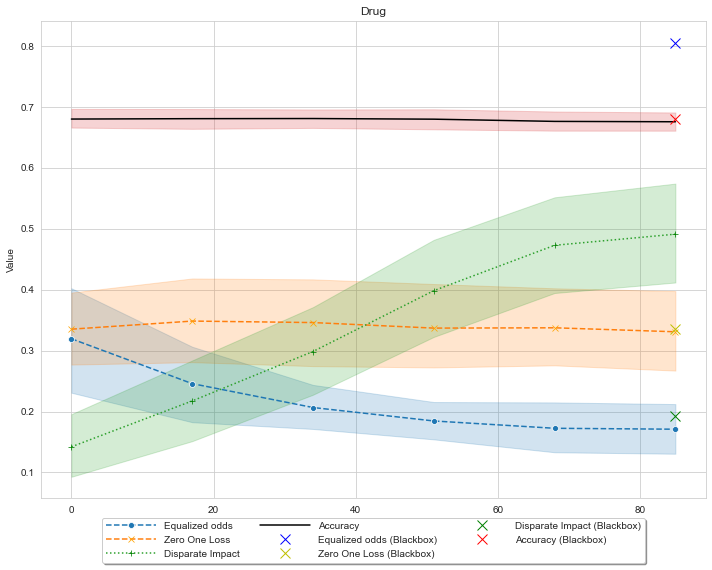

In [15]:
plot_metrics_curves(df, points, 'Drug')

In [16]:
unprivpergentage(data, protected_group, 89)

Dataset size: 1885
Unprivileged group size: 863
Percentage of unprivileged group: 45.782493368700266
Number of iterations: 89


In [17]:
save_metrics('blackbox', 'drug', blackboxmetrics)